# **Food Recommendation System**

**Dataset source: https://www.kaggle.com/datasets/schemersays/food-recommendation-system**

# **Preparation**

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d schemersays/food-recommendation-system

  0% 0.00/24.8k [00:00<?, ?B/s]
100% 24.8k/24.8k [00:00<00:00, 26.8MB/s]


In [ ]:
!unzip /content/food-recommendation-system.zip

Archive:  /content/food-recommendation-system.zip
  inflating: 1662574418893344.csv    
  inflating: ratings.csv             


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# libraries for content-based filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# libraries for collaborative filtering
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df_foods = pd.read_csv('/content/1662574418893344.csv')
df_ratings = pd.read_csv('/content/ratings.csv')

# **Data Understanding**

### **`df_foods`**

In [ ]:
df_foods.head(3)

,Food_ID,Name,C_Type,Veg_Non,Describe
0,1,summer squash salad,Healthy Food,veg,"white balsamic vinegar, lemon juice, lemon rin..."
1,2,chicken minced salad,Healthy Food,non-veg,"olive oil, chicken mince, garlic (minced), oni..."
2,3,sweet chilli almonds,Snack,veg,"almonds whole, egg white, curry leaves, salt, ..."


In [ ]:
df_foods.shape

(400, 5)

From this code cell above, it can be seen that the food dataset has 400 rows with 5 columns.

In [ ]:
df_foods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Food_ID   400 non-null    int64 
 1   Name      400 non-null    object
 2   C_Type    400 non-null    object
 3   Veg_Non   400 non-null    object
 4   Describe  400 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.8+ KB


In [ ]:
print(len(df_foods['C_Type'].unique()))
print(df_foods['C_Type'].unique())

16
['Healthy Food' 'Snack' 'Dessert' 'Japanese' 'Indian' 'French' 'Mexican'
 'Italian' 'Chinese' 'Beverage' 'Thai' 'Korean' ' Korean' 'Vietnames'
 'Nepalese' 'Spanish']


From the code cell above, it can be seen that there are 16 different food types in the dataset. But, it is noticed that Korean food has two unique values that must be corrected first. So, the code cell below is used to correct this one.

In [ ]:
df_foods['C_Type'] = df_foods['C_Type'].replace([' Korean'], 'Korean')

In [ ]:
print(len(df_foods['C_Type'].unique()))
print(df_foods['C_Type'].unique())

15
['Healthy Food' 'Snack' 'Dessert' 'Japanese' 'Indian' 'French' 'Mexican'
 'Italian' 'Chinese' 'Beverage' 'Thai' 'Korean' 'Vietnames' 'Nepalese'
 'Spanish']


In [ ]:
df_foods['C_Type'].value_counts().sort_values()

Spanish          1
Vietnames        9
Korean          10
Beverage        11
Nepalese        11
Japanese        18
Mexican         21
French          22
Snack           23
Thai            23
Italian         25
Chinese         27
Dessert         53
Healthy Food    58
Indian          88
Name: C_Type, dtype: int64

<Axes: >

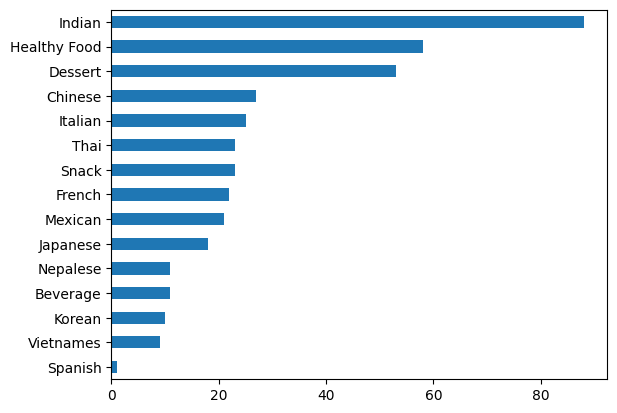

In [ ]:
df_foods['C_Type'].value_counts().sort_values().plot(kind='barh')

The code cell above is about the distribution plot of data about food types. From this plot, it can be shown that the most dominant food type belongs to Indian food, followed by Healthy Food and Dessert.

### **`df_ratings`**

In [ ]:
df_ratings.head(3)

,User_ID,Food_ID,Rating
0,1.0,88.0,4.0
1,1.0,46.0,3.0
2,1.0,24.0,5.0


In [ ]:
df_ratings.shape

(512, 3)

From this code cell above, it is known that the rating dataset has 512 rows with 3 columns.

In [ ]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   User_ID  511 non-null    float64
 1   Food_ID  511 non-null    float64
 2   Rating   511 non-null    float64
dtypes: float64(3)
memory usage: 12.1 KB


In [ ]:
print('Count of `User_ID`: ', len(df_ratings['User_ID'].unique()))
print('Count of `Food_ID`: ', len(df_ratings['Food_ID'].unique()))

Count of `User_ID`:  101
Count of `Food_ID`:  310


In [ ]:
df_ratings.describe()

,User_ID,Food_ID,Rating
count,511.000000,511.000000,511.000000
mean,49.068493,125.311155,5.438356
std,28.739213,91.292629,2.866236
min,1.000000,1.000000,1.000000
25%,25.000000,45.500000,3.000000
50%,49.000000,111.000000,5.000000
75%,72.000000,204.000000,8.000000
max,100.000000,309.000000,10.000000


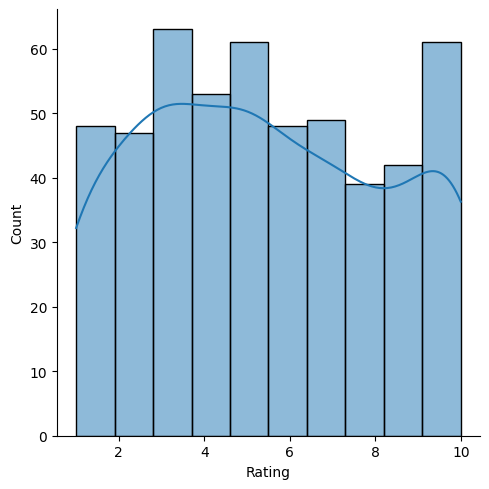

In [ ]:
sns.displot(df_ratings['Rating'], kde=True, bins=10)

The code cell above is about the distribution plot of data about rating. From this plot, it can be shown that the rating distribution tends to be around the numbers 3, 5, and 10.

# **Data Preprocessing**

In [ ]:
all_food_rate = df_ratings
all_food_rate

,User_ID,Food_ID,Rating
0,1.0,88.0,4.0
1,1.0,46.0,3.0
2,1.0,24.0,5.0
3,1.0,25.0,4.0
4,2.0,49.0,1.0
...,...,...,...
507,99.0,22.0,1.0
508,100.0,24.0,10.0
509,100.0,233.0,10.0
510,100.0,29.0,7.0


In [ ]:
all_food = pd.merge(all_food_rate,
                    df_foods[['Food_ID', 'Name', 'C_Type']],
                    on='Food_ID',
                    how='left')

all_food

,User_ID,Food_ID,Rating,Name,C_Type
0,1.0,88.0,4.0,peri peri chicken satay,Snack
1,1.0,46.0,3.0,steam bunny chicken bao,Japanese
2,1.0,24.0,5.0,green lentil dessert fudge,Dessert
3,1.0,25.0,4.0,cashew nut cookies,Dessert
4,2.0,49.0,1.0,christmas tree pizza,Italian
...,...,...,...,...,...
507,99.0,22.0,1.0,baked namak para,Snack
508,100.0,24.0,10.0,green lentil dessert fudge,Dessert
509,100.0,233.0,10.0,gluten free almond cake,Healthy Food
510,100.0,29.0,7.0,spinach and feta crepes,French


The code cell above is used to merge dataframe `all_food_rate` and dataframe `df_foods` based on `Food_ID` column

# **Data Preparation**

In [ ]:
all_food.isnull().sum()

User_ID    1
Food_ID    1
Rating     1
Name       1
C_Type     1
dtype: int64

The code cell above is used to check for missing value on dataframe `all_food`

In [ ]:
all_food = all_food.dropna()
all_food

,User_ID,Food_ID,Rating,Name,C_Type
0,1.0,88.0,4.0,peri peri chicken satay,Snack
1,1.0,46.0,3.0,steam bunny chicken bao,Japanese
2,1.0,24.0,5.0,green lentil dessert fudge,Dessert
3,1.0,25.0,4.0,cashew nut cookies,Dessert
4,2.0,49.0,1.0,christmas tree pizza,Italian
...,...,...,...,...,...
506,99.0,65.0,7.0,almond white chocolate gujiya,Japanese
507,99.0,22.0,1.0,baked namak para,Snack
508,100.0,24.0,10.0,green lentil dessert fudge,Dessert
509,100.0,233.0,10.0,gluten free almond cake,Healthy Food


The code cell above is used to remove missing value on dataframe `all_food`. Since there is only 1 row that has missing value, the food dataset now has 511 rows.

In [ ]:
df_ratings.isnull().sum()

User_ID    1
Food_ID    1
Rating     1
dtype: int64

The code cell above is used to check for missing value on dataframe `df_ratings`.

In [ ]:
df_ratings = df_ratings.dropna()
df_ratings

,User_ID,Food_ID,Rating
0,1.0,88.0,4.0
1,1.0,46.0,3.0
2,1.0,24.0,5.0
3,1.0,25.0,4.0
4,2.0,49.0,1.0
...,...,...,...
506,99.0,65.0,7.0
507,99.0,22.0,1.0
508,100.0,24.0,10.0
509,100.0,233.0,10.0


The code cell above is used for removing missing value on dataframe `df_ratings`. Since there is also only 1 row that has missing value, the rating dataset now has 511 rows.

In [ ]:
fix_food = all_food.sort_values('Food_ID', ascending=True)
fix_food

,User_ID,Food_ID,Rating,Name,C_Type
376,71.0,1.0,10.0,summer squash salad,Healthy Food
253,49.0,1.0,5.0,summer squash salad,Healthy Food
200,39.0,2.0,10.0,chicken minced salad,Healthy Food
50,9.0,2.0,3.0,chicken minced salad,Healthy Food
116,22.0,2.0,5.0,chicken minced salad,Healthy Food
...,...,...,...,...,...
302,56.0,305.0,9.0,sunga pork,Japanese
419,80.0,306.0,8.0,banana chips,Snack
381,71.0,307.0,1.0,bhurji- egg,Indian
494,97.0,308.0,3.0,flattened rice / poha,Indian


The code cell above is used to sort data based on `Food_ID` column.

In [ ]:
len(fix_food['Food_ID'].unique())

309

In [ ]:
fix_food['C_Type'].unique()

array(['Healthy Food', 'Snack', 'Dessert', 'Japanese', 'Indian', 'French',
       'Mexican', 'Italian', 'Chinese', 'Beverage', 'Thai'], dtype=object)

In [ ]:
preparation = fix_food
preparation.sort_values('Food_ID')

,User_ID,Food_ID,Rating,Name,C_Type
376,71.0,1.0,10.0,summer squash salad,Healthy Food
253,49.0,1.0,5.0,summer squash salad,Healthy Food
200,39.0,2.0,10.0,chicken minced salad,Healthy Food
50,9.0,2.0,3.0,chicken minced salad,Healthy Food
116,22.0,2.0,5.0,chicken minced salad,Healthy Food
...,...,...,...,...,...
302,56.0,305.0,9.0,sunga pork,Japanese
419,80.0,306.0,8.0,banana chips,Snack
381,71.0,307.0,1.0,bhurji- egg,Indian
494,97.0,308.0,3.0,flattened rice / poha,Indian


In [ ]:
preparation = preparation.drop_duplicates('Food_ID')
preparation

,User_ID,Food_ID,Rating,Name,C_Type
376,71.0,1.0,10.0,summer squash salad,Healthy Food
200,39.0,2.0,10.0,chicken minced salad,Healthy Food
456,89.0,3.0,7.0,sweet chilli almonds,Snack
457,90.0,4.0,6.0,tricolour salad,Healthy Food
144,28.0,5.0,10.0,christmas cake,Dessert
...,...,...,...,...,...
302,56.0,305.0,9.0,sunga pork,Japanese
419,80.0,306.0,8.0,banana chips,Snack
381,71.0,307.0,1.0,bhurji- egg,Indian
494,97.0,308.0,3.0,flattened rice / poha,Indian


This code cell above is used for removing duplicate rows based on `Food_ID` column. After implementing the above code cell, the remaining rows are 309 rows.

In [ ]:
preparation['C_Type'][preparation['C_Type'] == 'Healthy Food'] = 'Healthy_Food'

In [ ]:
food_id = preparation['Food_ID'].tolist()
food_name = preparation['Name'].tolist()
food_category = preparation['C_Type'].tolist()

print(len(food_id))
print(len(food_name))
print(len(food_category))

309
309
309


This code cell above is used for converting `Food_ID`, `Name`, and `C_Type` series into list.

In [ ]:
food_new = pd.DataFrame({
    'id': food_id,
    'food_name': food_name,
    'category': food_category
})

food_new

,id,food_name,category
0,1.0,summer squash salad,Healthy_Food
1,2.0,chicken minced salad,Healthy_Food
2,3.0,sweet chilli almonds,Snack
3,4.0,tricolour salad,Healthy_Food
4,5.0,christmas cake,Dessert
...,...,...,...
304,305.0,sunga pork,Japanese
305,306.0,banana chips,Snack
306,307.0,bhurji- egg,Indian
307,308.0,flattened rice / poha,Indian


The code cell above is used to create dictionary for `food_id`, `food_name`, and `food_category`.

# **Modeling**

## **1. Content-Based Filtering**

In [ ]:
data = food_new
data.sample(5)

,id,food_name,category
199,200.0,chocolate kaju katli,Dessert
98,99.0,spicy chicken masala,Indian
216,217.0,mustard-parmesan whole roasted cauliflower,Healthy_Food
102,103.0,amritsari chicken masala,Indian
54,55.0,filo pizza,Italian


In [ ]:
tf = TfidfVectorizer()

tf.fit(data['category'])

tf.get_feature_names_out()

array(['beverage', 'chinese', 'dessert', 'french', 'healthy_food',
       'indian', 'italian', 'japanese', 'mexican', 'snack', 'thai'],
      dtype=object)

The code cell above performs TfidfVectorizer initialization, followed by determining idf on the food types and mapping array from integer index feature to name feature.

In [ ]:
tfidf_matrix = tf.fit_transform(data['category'])

tfidf_matrix.shape

(309, 11)

The code cell above is used to do fit_transform into matrix form and check the shape of the matrix.

In [ ]:
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]])

The code cell above is used to change tf-idf vector into matrix using todense() function.

In [ ]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=data['food_name']
).sample(11, axis=1).sample(10, axis=0)

,mexican,beverage,thai,indian,healthy_food,snack,french,dessert,italian,chinese,japanese
food_name,,,,,,,,,,,
egg and garlic fried rice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
veg fried rice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
fruit cube salad,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
avial with red rice,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
almond pearls,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
coffee marinated mutton chops,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
caramelized sesame smoked almonds,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
chicken and mushroom lasagna,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
andhra crab meat masala,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The code cell above is used to create dataframe to see tf-idf matrix, with the column filled by food type and the row filled by food name.

In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

The code cell above is used to determine cosine similarity on tf-idf matrix.

In [ ]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['food_name'], columns=data['food_name'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (309, 309)


food_name,fruit infused tea,cheese and ham roll,spiced almond banana jaggery cake,baked almond kofta,half roast chicken
food_name,,,,,
cheese chicken kebabs,0.0,0.0,0.0,0.0,0.0
chicken tenders,0.0,1.0,0.0,1.0,0.0
black rice,0.0,0.0,0.0,0.0,1.0
buldak (hot and spicy chicken),0.0,0.0,0.0,0.0,0.0
cheese and ham roll,0.0,1.0,0.0,1.0,0.0
puffed rice squares,0.0,1.0,0.0,1.0,0.0
fish ambultiyal,0.0,0.0,0.0,0.0,0.0
roast turkey with cranberry sauce,0.0,0.0,0.0,0.0,1.0
egg and cheddar cheese sandwich,0.0,0.0,0.0,0.0,0.0


The code cell above is used to create new dataframe from `cosine_sim` with rows and columns as food_name, then followed by checking similarity matrix on each food.

In [ ]:
def food_recommendations(food_name, similarity_data=cosine_sim_df, items=data[['food_name', 'category']], k=5):
  index = similarity_data.loc[:,food_name].to_numpy().argpartition(range(-1, -k, -1))

  closest = similarity_data.columns[index[-1:-(k+2):-1]]

  closest = closest.drop(food_name, errors='ignore')

  return pd.DataFrame(closest).merge(items).head(k)

The code cell above is used to create a function that can be used to give food recommendation with the input is a food name. The function will first fetch data by using argpartition for indirectly partition along the given axis, pick data with greatest similarity from the existing index, and drop `food_name` so that the searched food name is not appear in the recommendation result.

In [ ]:
data[data['food_name'].eq('banana chips')]

,id,food_name,category
305,306.0,banana chips,Snack


In [ ]:
food_recommendations('banana chips')

,food_name,category
0,puffed rice,Snack
1,californian breakfast benedict,Snack
2,banana phirni tartlets with fresh strawberries,Snack
3,baked raw banana samosa,Snack
4,baked multigrain murukku,Snack


The output of the code cell above shows the food recommendation results. It can be seen that the function outputs 5 food names that have the same category as the food name that has been inputted before, that is Snack category.

## **2. Collaborative Filtering**

In [ ]:
df_ratings

,User_ID,Food_ID,Rating
0,1.0,88.0,4.0
1,1.0,46.0,3.0
2,1.0,24.0,5.0
3,1.0,25.0,4.0
4,2.0,49.0,1.0
...,...,...,...
506,99.0,65.0,7.0
507,99.0,22.0,1.0
508,100.0,24.0,10.0
509,100.0,233.0,10.0


In [ ]:
# Changing `User_ID` to list without same value
user_ids = df_ratings['User_ID'].unique().tolist()
print('list User_ID: ', user_ids)

# Encoding `User_ID`
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded User_ID : ', user_to_user_encoded)

# Encoding process number to `User_ID`
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded number to User_ID: ', user_encoded_to_user)

list User_ID:  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0]
encoded User_ID :  {1.0: 0, 2.0: 1, 3.0: 2, 4.0: 3, 5.0: 4, 6.0: 5, 7.0: 6, 8.0: 7, 9.0: 8, 10.0: 9, 11.0: 10, 12.0: 11, 13.0: 12, 14.0: 13, 15.0: 14, 16.0: 15, 17.0: 16, 18.0: 17, 19.0: 18, 20.0: 19, 21.0: 20, 22.0: 21, 23.0: 22, 24.0: 23, 25.0: 24, 26.0: 25, 27.0: 26, 28.0: 27, 29.0: 28, 30.0: 29, 31.0: 30, 32.0: 31, 33.0: 32, 34.0: 33, 35.0: 34, 36.0: 35, 37.0: 36, 38.0: 37, 39.0: 38, 4

The code cell above is used to encode the `User_ID`.

In [ ]:
# Changing `Food_ID` to list without same value
food_ids = df_ratings['Food_ID'].unique().tolist()

# Encoding `Food_ID`
food_to_food_encoded = {x: i for i, x in enumerate(food_ids)}

# Encoding process number to `Food_ID`
food_encoded_to_food = {i: x for i, x in enumerate(food_ids)}

The code cell above is used to encode the `Food_ID`.

In [ ]:
# Mapping `User_ID` to dataframe user
df_ratings['user'] = df_ratings['User_ID'].map(user_to_user_encoded)

# Mapping `Food_ID` to dataframe food
df_ratings['food'] = df_ratings['Food_ID'].map(food_to_food_encoded)

The code cell above is used to do mapping the `User_ID` and `Food_ID` to dataframe user and food respectively.

In [ ]:
# Check for number of users
num_users = len(user_to_user_encoded)
print(num_users)

# Check for number of foods
num_food = len(food_encoded_to_food)
print(num_food)

# Changing rating into floating numbers
df_ratings['rating'] = df_ratings['Rating'].values.astype(np.float32)

# Minimum value of rating
min_rating = min(df_ratings['rating'])

# Maximum value of rating
max_rating = max(df_ratings['rating'])

print('Number of User: {}, Number of Food: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_food, min_rating, max_rating
    )
)

100
309
Number of User: 100, Number of Food: 309, Min Rating: 1.0, Max Rating: 10.0


The code cell above is used to check the number of users, number of foods, and the minimum also the maximum value of rating available on the dataset.

In [ ]:
df_ratings = df_ratings.sample(frac=1, random_state=42)
df_ratings

,User_ID,Food_ID,Rating,user,food,rating
124,24.0,51.0,5.0,23,67,5.0
84,16.0,243.0,3.0,15,78,3.0
433,83.0,79.0,1.0,82,282,1.0
255,49.0,77.0,10.0,48,191,10.0
68,13.0,74.0,8.0,12,64,8.0
...,...,...,...,...,...,...
106,19.0,84.0,10.0,18,97,10.0
270,51.0,151.0,10.0,50,200,10.0
348,67.0,146.0,7.0,66,209,7.0
435,84.0,253.0,8.0,83,283,8.0


The code cell above is used to shuffle the dataset.

In [ ]:
# Creating `x` variable to match user and food data into one value
x = df_ratings[['user', 'food']].values

# Creating `y` variable to make rating from the result
y = df_ratings['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Data splitting into 80% training set and 20% validation set
train_indices = int(0.8 * df_ratings.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 23  67]
 [ 15  78]
 [ 82 282]
 ...
 [ 66 209]
 [ 83 283]
 [ 18  93]] [0.44444444 0.22222222 0.         1.         0.77777778 1.
 1.         0.88888889 0.88888889 0.44444444 0.88888889 1.
 0.22222222 0.44444444 1.         0.44444444 0.11111111 0.44444444
 0.66666667 0.11111111 0.55555556 0.77777778 0.66666667 0.55555556
 0.22222222 1.         0.55555556 0.44444444 0.77777778 0.11111111
 0.77777778 0.11111111 0.66666667 0.33333333 1.         1.
 1.         0.77777778 0.55555556 1.         0.33333333 0.55555556
 1.         0.33333333 0.44444444 0.44444444 0.44444444 0.33333333
 0.44444444 0.22222222 0.77777778 0.         0.33333333 0.
 0.66666667 0.11111111 0.77777778 1.         0.         0.11111111
 1.         0.33333333 0.44444444 1.         0.22222222 0.77777778
 0.33333333 0.77777778 0.88888889 0.         0.55555556 0.55555556
 0.55555556 0.66666667 0.22222222 0.66666667 0.44444444 0.44444444
 0.33333333 0.44444444 0.66666667 0.77777778 0.         0.44444444
 1.         0.33333333

The code cell above is used to create the `x` and `y` variables, followed by data splitting.

In [ ]:
class RecommenderNet(tf.keras.Model):
  def __init__(self, num_users, num_food, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_food = num_food
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.food_embedding = layers.Embedding( # layer embeddings food
        num_food,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.food_bias = layers.Embedding(num_food, 1) # layer embedding food bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # calling first embedding layer
    user_bias = self.user_bias(inputs[:, 0]) # calling second embedding layer
    food_vector = self.food_embedding(inputs[:, 1]) # calling third embedding layer
    food_bias = self.food_bias(inputs[:, 1]) # calling fourth embedding layer

    dot_user_food = tf.tensordot(user_vector, food_vector, 2)

    x = dot_user_food + user_bias + food_bias

    return tf.nn.sigmoid(x) # activation sigmoid

The code cell above is used to create class RecommenderNet with keras Model class.

In [ ]:
model = RecommenderNet(num_users, num_food, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

The code cell above is used to compile the model. This model uses Binary Crossentropy to calculate the loss function, Adam (Adaptive Moment Estimation) as the optimizer, and Root Mean Squared Error (RMSE) as the evaluation metric.

In [ ]:
# Training process

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=9,
    epochs=50,
    validation_data=(x_val, y_val)
)

Epoch 1/50
46/46 [==============================] - 1s 9ms/step - loss: 0.6949 - root_mean_squared_error: 0.3200 - val_loss: 0.7123 - val_root_mean_squared_error: 0.3303
Epoch 2/50
46/46 [==============================] - 0s 4ms/step - loss: 0.6936 - root_mean_squared_error: 0.3190 - val_loss: 0.7121 - val_root_mean_squared_error: 0.3302
Epoch 3/50
46/46 [==============================] - 0s 4ms/step - loss: 0.6994 - root_mean_squared_error: 0.3233 - val_loss: 0.7119 - val_root_mean_squared_error: 0.3300
Epoch 4/50
46/46 [==============================] - 0s 4ms/step - loss: 0.6991 - root_mean_squared_error: 0.3232 - val_loss: 0.7116 - val_root_mean_squared_error: 0.3298
Epoch 5/50
46/46 [==============================] - 0s 4ms/step - loss: 0.6960 - root_mean_squared_error: 0.3208 - val_loss: 0.7113 - val_root_mean_squared_error: 0.3296
Epoch 6/50
46/46 [==============================] - 0s 4ms/step - loss: 0.6917 - root_mean_squared_error: 0.3175 - val_loss: 0.7110 - val_root_mean_sq

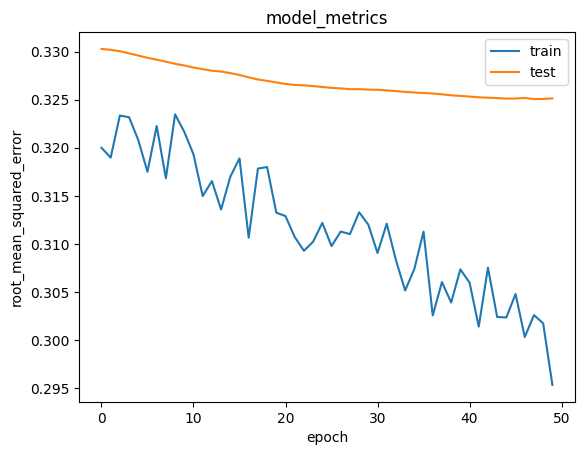

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

From the metric visualization on the output of the code cell above, it can be seen that there is decrease trend of the RMSE in each epoch both in training and evaluation data. This indicates that the model can learn properly from the data. From this visualization, it can also be seen that a final error value of 0.3110 was obtained with an error in the validation data of 0.3261.

In [ ]:
food_df = food_new
df = pd.read_csv('ratings.csv')

user_id = df['User_ID'].sample(1).iloc[0]
food_tasted_by_user = df[df['User_ID'] == user_id]

food_not_tasted = food_df[~food_df['id'].isin(food_tasted_by_user['Food_ID'].values)]['id']
food_not_tasted = list(
    set(food_not_tasted)
    .intersection(set(food_to_food_encoded.keys()))
)

food_not_tasted = [[food_to_food_encoded.get(x)] for x in food_not_tasted]
food_not_tasted
user_encoder = user_to_user_encoded.get(user_id)
user_food_array = np.hstack(
    ([[user_encoder]] * len(food_not_tasted), food_not_tasted)
)

The code cell above is used to create a new variable called `food_not_tasted` as the food list that can be used for recommendation to the user.

In [ ]:
ratings = model.predict(user_food_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_food_ids = [food_encoded_to_food.get(food_not_tasted[x][0]) for x in top_ratings_indices]

print('Showing recommendations for users: {}'.format(int(user_id)))
print('===' * 9)
print('Food with high ratings from user')
print('----' * 8)

top_food_user = (
    food_tasted_by_user.sort_values(
        by='Rating',
        ascending=False
    )
    .head(5)
    .Food_ID.values
)

food_df_rows = food_df[food_df['id'].isin(top_food_user)]
for row in food_df_rows.itertuples():
  print(row.food_name, ':', row.category)

print('----' * 8)
print('Top 10 food recommendation')
print('----' * 8)

recommended_food = food_df[food_df['id'].isin(recommended_food_ids)]
for row in recommended_food.itertuples():
  print(row.food_name, ':', row.category)

10/10 [==============================] - 0s 8ms/step
Showing recommendations for users: 73
Food with high ratings from user
--------------------------------
christmas cake : Dessert
chocolate samosa : Snack
bengali lamb curry : Indian
cinnamon star cookies : Dessert
--------------------------------
Top 10 food recommendation
--------------------------------
chicken minced salad : Healthy_Food
japanese curry arancini with barley salsa : Japanese
chocolate nero cookies : Dessert
watermelon and strawberry smoothie : Healthy_Food
baked namakpara with roasted almond dip : Snack
grilled almond barfi : Dessert
cashew nut cookies : Dessert
hawaiin papaya salad : Healthy_Food
almond and amaranth ladoo : Dessert
moong dal kiwi coconut soup : Indian


The code cell above performs the food recommendation for a user with `User_ID` 73. From the output, it can be seen that there are 10 food recommended to this user.